# Housing Sales Prices & Venues Data Analysis of Manchester

### Description and Disscusion of the Background

Manchester is within the United Kingdom's second-most populous urban area with a population of 545,500 and it has seen considerable investment and regeneration in recent years. Manchester is known for its culture, architecture, sports clubs, transport connections and social impact, which attracts many people of young age. However, as most of these people have just started their careers, they need to find a place where the real estate values are lower but also surrounded by venues of their preference, which can be difficult to find.

This projects aims to create an analysis of features of Manchester neighbourhoods, including average property prices, value per square foot and density of venues. This would help people that want to move to Manchester but do not know the area well,so they can make a more informed decision about which neighbourhood to live in. Considering these points, I will create a segmented map and information charts including housing prices and each area will be clustered according to its venue density.

### Data Description

1. For the coordinates, I will use the data found on https://www.doogal.co.uk/AdministrativeAreas.php?district=E08000003. From this dataset, we will obtain the **Postcode, names, latitude and longitude** of each neighbbourhood. With the Python library *Pandas*, I will format the data, cleaning and reducing it to what we actually need.

2. I'll use Foursquare API to get the most common venues in Manchester, this API provides diverse information about venues within a chosen radius of 500m. From this, we will be able to get information about the venues such as the **venue's neighbourhood, name, location and category**.

3. For housing prices, I'll use the data downloaded from https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianpricepaidbywardhpssadataset37 and save it as a pandas dataframe, the table includes **the ward names, median price paid by ward in England from 1995 to 2018**.

## Part 1: creating and cleaning the dataframe

### Part 1.1: create a dataframe with the Postcodes and their coordinates for each neighbourhood in Manchester

Using the data found on https://www.doogal.co.uk/AdministrativeAreas.php?district=E08000003 

In [1]:
#importing the libraries
# library for data analsysis
import pandas as pd

# library to handle data in a vectorized manner
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests

from sklearn.cluster import KMeans
from sklearn import metrics

!conda install -c conda-forge folium=0.5.0 --yes
import folium

# convert an address into latitude and longitude values
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries installed and imported!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total: 

In [2]:
#saving the coordinates data into a pandas dataframe called df
df=pd.read_csv('https://www.doogal.co.uk/AdministrativeAreasCSV.ashx?district=E08000003')
df.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,Ward,Parish,Introduced,Terminated,Altitude,Country,Last Updated,Quality,LSOA Code
0,M1 1AA,No,53.487362,-2.227197,385022,398985,SJ850989,Piccadilly,"Manchester, unparished area",1995-07-01,2009-04-01,54,England,2019-05-29,Within the building of the matched address clo...,E01033651
1,M1 1AD,Yes,53.483885,-2.244839,383850,398602,SJ838986,Deansgate,"Manchester, unparished area",2003-03-01,NaN,46,England,2019-05-29,Within the building of the matched address clo...,E01033658
2,M1 1AE,Yes,53.483471,-2.231184,384756,398553,SJ847985,Piccadilly,"Manchester, unparished area",2005-01-01,NaN,56,England,2019-05-29,Within the building of the matched address clo...,E01033659
3,M1 1AF,Yes,53.480547,-2.237150,384359,398229,SJ843982,Piccadilly,"Manchester, unparished area",2005-06-01,NaN,52,England,2019-05-29,Within the building of the matched address clo...,E01033653
4,M1 1AG,Yes,53.483282,-2.231454,384738,398532,SJ847985,Piccadilly,"Manchester, unparished area",2010-03-01,NaN,56,England,2019-05-29,Within the building of the matched address clo...,E01033659


In [3]:
#dropping the columns that we will not use
df.drop(['Easting','Northing','Grid Ref','Parish','Introduced','Terminated','Altitude','Country','Last Updated','Quality','LSOA Code',],axis=1,inplace=True)

#get only the postcodes that are still in use
df=df[df['In Use?'] != 'No']
df.reset_index(drop=True,inplace=True)

#drop the columns we will not need
df.drop(['In Use?'],axis=1,inplace=True)

#keep only the first part of the postcode, e.g. M1,M2..
df['Postcode'] = df['Postcode'].map(lambda x: str(x)[:-4])

#get only the postcodes from manchester city, which are the ones that start with M.
df = df[df['Postcode'].str.startswith('M')]

df.head()

,Postcode,Latitude,Longitude,Ward
0,M1,53.483885,-2.244839,Deansgate
1,M1,53.483471,-2.231184,Piccadilly
2,M1,53.480547,-2.237150,Piccadilly
3,M1,53.483282,-2.231454,Piccadilly
4,M1,53.483701,-2.233295,Piccadilly


In [4]:
#group by ward
df_ward=df[['Ward','Postcode']]
df_ward_group=df_ward.groupby(['Ward'],sort=False)['Postcode'].apply(lambda x: '' if x.isnull().any() else ','.join(set(x.astype(str).values)))
df_ward=pd.DataFrame(df_ward_group)

#create a dataframe with the ward and coordinate columns
df_ll_ward=df[['Ward','Latitude','Longitude']]

#group by postcode, getting the coordinates for each one of them
df_ll_ward_group=df_ll_ward.groupby('Ward')['Latitude','Longitude'].mean()

#join dataframes
#our final dataframe contains each Ward, its Latitude and Longitude coordinates and the postcodes of the city of Manchester
df_coords=df_ward.combine_first(df_ll_ward_group)
df_coords.reset_index(inplace=True)
df_coords.head()

,Ward,Latitude,Longitude,Postcode
0,Ancoats & Beswick,53.481157,-2.213328,"M4,M11,M12,M40"
1,Ardwick,53.465800,-2.217067,"M1,M14,M12,M18,M13,M15"
2,Baguley,53.390994,-2.284337,M23
3,Brooklands,53.406481,-2.296419,"M33,M23"
4,Burnage,53.431485,-2.203522,"M19,M20"


In [5]:
df_coords.shape

(32, 4)

# Housing prices

### Part 1.2: create a dataframe with the Ward name, average property prices for each ward in the year of 2018 in Manchester.

Using the dataset downloaded from https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/housing/datasets/medianpricepaidbywardhpssadataset37/yearendingdecember2018/hpssadataset37medianpricepaidbyward.zip and uploaded to my project in Watson Studio. The dataset includes the **Median price paid by ward** in England and Wales, for the years ending in December 1995 to December 2018

In [5]:
df_data=pd.read_csv('/resources/data/Manchester/prices_per_ward.csv')
df_data.head()

,Local authority code,Local authority name,Ward code,Ward name,Year ending Dec 1995,Year ending Mar 1996,Year ending Jun 1996,Year ending Sep 1996,Year ending Dec 1996,Year ending Mar 1997,...,Year ending Sep 2018,Year ending Dec 2018,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104
0,E06000001,Hartlepool,E05008942,Burn Valley,"29,750","29,850","30,000","30,000","30,250","30,000",...,"83,500","82,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E06000001,Hartlepool,E05008943,De Bruce,"38,000","38,000","37,000","30,500","30,000","30,500",...,"124,225","121,375",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E06000001,Hartlepool,E05008944,Fens and Rossmere,"51,000","51,000","50,000","47,975","47,500","47,500",...,"130,000","128,500",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E06000001,Hartlepool,E05008945,Foggy Furze,"39,000","39,000","39,000","38,625","38,250","38,250",...,"102,000","95,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E06000001,Hartlepool,E05008946,Hart,"56,500","56,500","56,500","56,950","58,425","59,950",...,"152,000","155,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will only use the data for most recent year, 2018.

In [6]:
#create a dataframe with only the columns we will use
df_pr=df_data[['Local authority name','Ward name','Year ending Dec 2018']]

#get the rows corresponding to Manchester
df_price=df_pr.loc[df_pr['Local authority name']=='Manchester']
df_price.reset_index(drop=True,inplace=True)
df_price.head()

,Local authority name,Ward name,Year ending Dec 2018
0,Manchester,Ancoats & Beswick,"203,250"
1,Manchester,Ardwick,"191,995"
2,Manchester,Baguley,"150,000"
3,Manchester,Brooklands,"172,000"
4,Manchester,Burnage,"192,000"


In [8]:
#drop the Local authority name column, as it won't be used anymore
df_price.drop(['Local authority name'],axis=1,inplace=True)

#format the price in the 'Year ending Dec 2018' column from str to int
df_price['Year ending Dec 2018'] = pd.to_numeric(df_price['Year ending Dec 2018'].str.replace(',', ''), errors='coerce')

#rename the column 'Area' to 'Postcode' and 'Avg price' to 'Average Price (£)'
df_price.rename(columns={'Ward name':'Ward','Year ending Dec 2018': 'Median price by Ward'},inplace=True)

#check the shape of both dataframes we will join:
print(df_coords.shape)
print(df_price.shape)

df_price.head()

(32, 4)
(32, 2)


,Ward,Median price by Ward
0,Ancoats & Beswick,203250
1,Ardwick,191995
2,Baguley,150000
3,Brooklands,172000
4,Burnage,192000


In [9]:
#check the types of the columns
df_price.dtypes

Ward                    object
Median price by Ward     int64
dtype: object

In [10]:
#top 5 most expensive wards in 2018
df_price.sort_values('Median price by Ward',ascending=False).head(5)

,Ward,Median price by Ward
7,Chorlton,334000
12,Didsbury East,315000
13,Didsbury West,299995
8,Chorlton Park,280650
11,Deansgate,224975


In [11]:
#top 5 least expensive wards in 2018
df_price.sort_values('Median price by Ward',ascending=True).head(5)

,Ward,Median price by Ward
16,Harpurhey,93250
15,Gorton & Abbey Hey,116000
17,Higher Blackley,118500
23,Moston,122000
20,Longsight,130000


### Merging both dataframes

In [12]:
#now that we have the same shape we will merge both dataframes
df_merge=df_price.merge(df_coords)
df_merge.head()

,Ward,Median price by Ward,Latitude,Longitude,Postcode
0,Ancoats & Beswick,203250,53.481157,-2.213328,"M4,M11,M12,M40"
1,Ardwick,191995,53.465800,-2.217067,"M1,M14,M12,M18,M13,M15"
2,Baguley,150000,53.390994,-2.284337,M23
3,Brooklands,172000,53.406481,-2.296419,"M33,M23"
4,Burnage,192000,53.431485,-2.203522,"M19,M20"


## Part 2: analyzing the data

### Part 2.1: Histograms

A histogram is a way of representing the *frequency* distribution of numeric dataset. The way it works is it partitions the x-axis into *bins*, assigns each data point in our dataset to a bin, and then counts the number of data points that have been assigned to each bin. So the y-axis is the frequency or the number of data points in each bin. Note that we can change the bin size and usually one needs to tweak it so that the distribution is displayed nicely. By default, the `histrogram` method breaks up the dataset into 10 bins.

Histogram for the average property sale price in Manchester in 2018

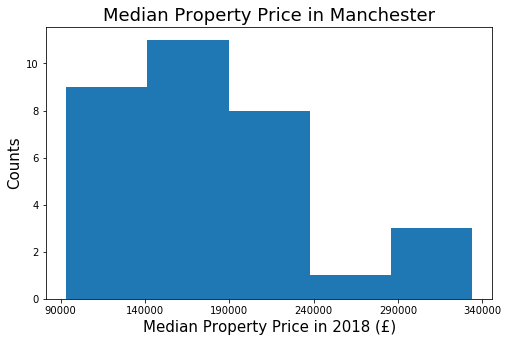

In [13]:
#'bin_edges' is a list of bin intervals
first_edge, last_edge = df_merge['Median price by Ward'].min(), df_merge['Median price by Ward'].max()
n_equal_bins = 5 # choose number of bins wanted, default =10
bin_edges = np.linspace(start=first_edge-3250, stop=last_edge+6000, num=n_equal_bins + 1, endpoint=True)

df_merge['Median price by Ward'].plot(kind='hist', figsize=(8, 5),bins=n_equal_bins, xticks=bin_edges)
plt.xlabel("Median Property Price in 2018 (£)",fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.title('Median Property Price in Manchester',fontsize=18)
plt.show()

The ranges in the *histogram* can be defined as below:

1. Up to £140k: Low Level HSP
2. £140k-£190k: Mid-1 Level HSP
3. £190k-£240k: Mid-2 Level HSP
4. £240k-£290k: High-1 Level HSP
5. More than £290k: High-2 Level HSP

Histogram for the property price per square foot in Manchester in 2019

### Part 2.2: Bar charts

A bar plot is a way of representing data where the *length* of the bars represents the magnitude/size of the feature/variable. Bar graphs usually represent numerical and categorical variables grouped in intervals.

This bar chart representes the average property price in Manchester in 2019 for different neighbourhoods, represented by their postcodes.

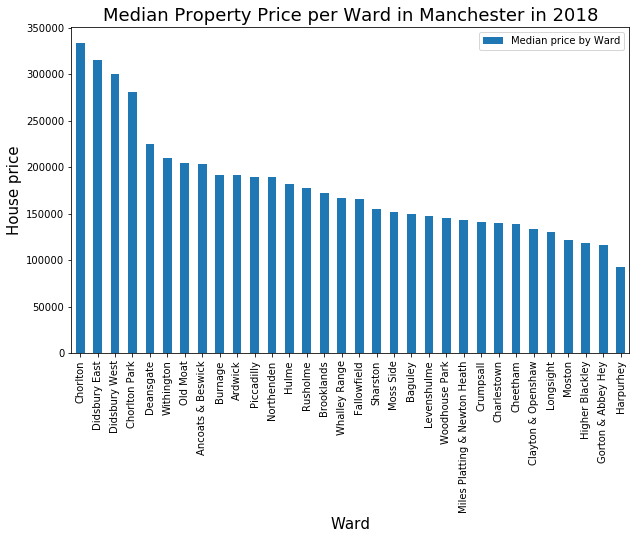

In [14]:
df_merge.sort_values('Median price by Ward',ascending=False).plot(x='Ward',y='Median price by Ward',kind='bar', figsize=(10, 6))

plt.xlabel('Ward',fontsize=15) # add to x-label to the plot
plt.ylabel('House price',fontsize=15) # add y-label to the plot
plt.title('Median Property Price per Ward in Manchester in 2018', fontsize=18) # add title to the plot

plt.show()

## Part 3: creating a map of Manchester

#### Use geopy library to get the latitude and longitude values of Manchester.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>mcr_explorer</em>.

In [15]:
#getting the coordinates for Manchester

address = 'Manchester'

geolocator = Nominatim(user_agent="mcr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manchester are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manchester are 53.4794892, -2.2451148.


Let's create a map of Manchester using the Python library *Folium*. Then, superimpose the locations of the wards onto the map. The way to do that in **Folium** is to create a *feature group* with its own features and style and then add it to the man_map.

In [16]:
# create map and display it
man_map = folium.Map(location=[latitude, longitude], zoom_start=11.8)

# loop through the 100 crimes and add each to the map
for lat, lng, label in zip(df_merge.Latitude, df_merge.Longitude, df_merge.Ward):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(man_map)

# show map
man_map

## Part 4: Foursquare API

We are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

### 4.1: Credentials

In [17]:
#get the credentials from Foursquare
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20190807' # Foursquare API version

### 4.2 Explore the Wards in Manchester

Let's create a function to get the top 100 venues that are in each ward within a radius of 500 meters.

In [18]:
#limit number of venues
limit=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each ward and create a new dataframe called *mcr_venues*.

In [19]:
mcr_venues = getNearbyVenues(names=df_merge['Ward'],
                                   latitudes=df_merge['Latitude'],
                                   longitudes=df_merge['Longitude'])

#check the size of the resulting dataframe
print(mcr_venues.shape)
mcr_venues.head()

Ancoats & Beswick
Ardwick
Baguley
Brooklands
Burnage
Charlestown
Cheetham
Chorlton
Chorlton Park
Clayton & Openshaw
Crumpsall
Deansgate
Didsbury East
Didsbury West
Fallowfield
Gorton & Abbey Hey
Harpurhey
Higher Blackley
Hulme
Levenshulme
Longsight
Miles Platting & Newton Heath
Moss Side
Moston
Northenden
Old Moat
Piccadilly
Rusholme
Sharston
Whalley Range
Withington
Woodhouse Park
(424, 7)


,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ancoats & Beswick,53.481157,-2.213328,Holt Town Metrolink Station,53.483306,-2.212095,Tram Station
1,Ancoats & Beswick,53.481157,-2.213328,Royle Basin Park,53.479560,-2.217871,Park
2,Ancoats & Beswick,53.481157,-2.213328,Cloud Aerial Arts,53.484400,-2.214019,Gym / Fitness Center
3,Ancoats & Beswick,53.481157,-2.213328,Planet Medlock,53.477863,-2.210520,Park
4,Ancoats & Beswick,53.481157,-2.213328,New Islington Metrolink Station,53.480948,-2.219915,Tram Station


In [20]:
#Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(mcr_venues['Venue Category'].unique())))

There are 132 uniques categories.


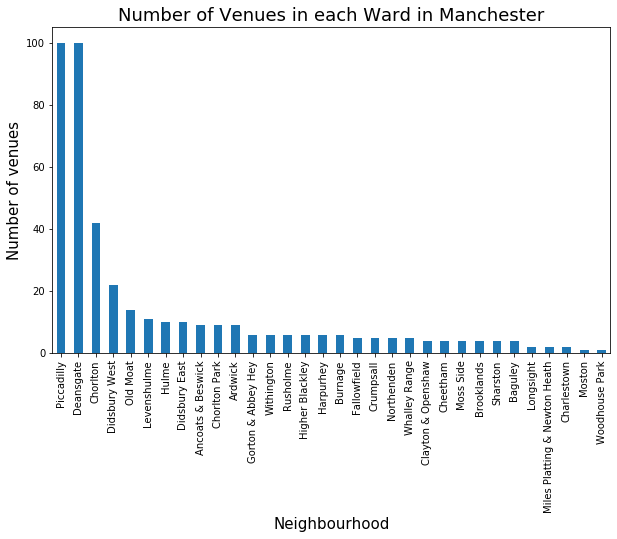

In [21]:
#bar chart that representes the number of venues per ward
df_n_venues = mcr_venues.groupby('Ward').count().reset_index()

df_n_venues=df_n_venues.sort_values(by='Venue',ascending=False)

df_n_venues.plot(x='Ward',y='Venue',kind='bar', figsize=(10, 6),legend=None)

plt.xlabel('Neighbourhood',fontsize=15) # add to x-label to the plot
plt.ylabel('Number of venues',fontsize=15) # add y-label to the plot
plt.title('Number of Venues in each Ward in Manchester',fontsize=18) # add title to the plot

plt.show()

Because many of the wards have a small number of venues, we will consider only the top 10 that have the most venues.

In [22]:
#check how many venues were returned for each ward
mcr_top10=df_n_venues.head(10)
mcr_top10.reset_index(drop=True,inplace=True)

mcr_top10

,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Piccadilly,100,100,100,100,100,100
1,Deansgate,100,100,100,100,100,100
2,Chorlton,42,42,42,42,42,42
3,Didsbury West,22,22,22,22,22,22
4,Old Moat,14,14,14,14,14,14
5,Levenshulme,11,11,11,11,11,11
6,Hulme,10,10,10,10,10,10
7,Didsbury East,10,10,10,10,10,10
8,Chorlton Park,9,9,9,9,9,9
9,Ardwick,9,9,9,9,9,9


In [24]:
#getting the Wards that match between both datasets
intersect=[]
nomatch=[]
for a in mcr_venues['Ward']:
    for b in mcr_top10['Ward']:
        if a == b:
            intersect.append(a)
        else:
            nomatch.append(a)

#dropping rows that are not in the intersection list
mcr_venues=mcr_venues[mcr_venues['Ward'].isin(intersect)]
mcr_venues.reset_index(drop=True,inplace=True)

#doing the same for df_merge
mcr_complete=df_merge[df_merge['Ward'].isin(intersect)]
mcr_complete.reset_index(drop=True,inplace=True)
mcr_complete

mcr_venues.shape

(327, 7)

In [25]:
#Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(mcr_venues['Venue Category'].unique())))

There are 106 uniques categories.


Let's plot the number of venues per Ward for the top 10 Wards

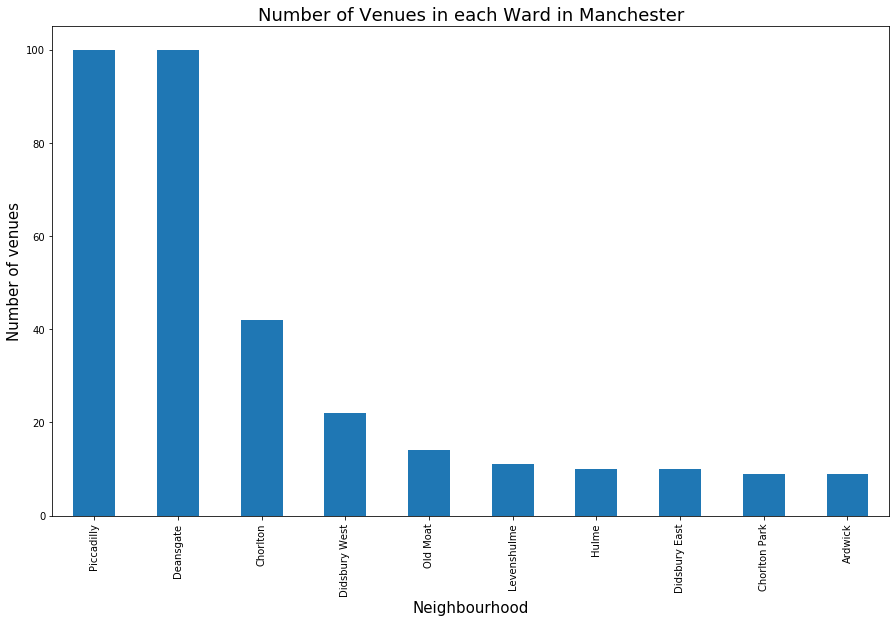

In [25]:
mcr_top10.plot(x='Ward',y='Venue',kind='bar',figsize=(15,9),legend=None)

plt.xlabel('Neighbourhood',fontsize=15) # add to x-label to the plot
plt.ylabel('Number of venues',fontsize=15) # add y-label to the plot
plt.title('Number of Venues in each Ward in Manchester',fontsize=18) # add title to the plot
plt.show()

And the Median price by ward for the top 10 wards

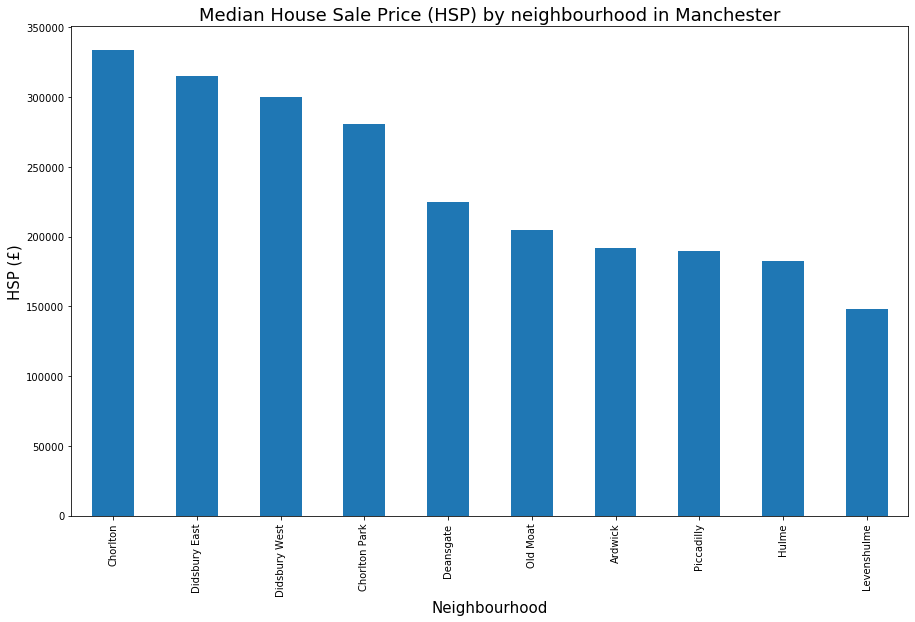

In [26]:
mcr_complete.sort_values('Median price by Ward',ascending=False).plot(x='Ward',y='Median price by Ward',kind='bar',figsize=(15,9),legend=None)

plt.xlabel('Neighbourhood',fontsize=15) # add to x-label to the plot
plt.ylabel('HSP (£)',fontsize=15) # add y-label to the plot
plt.title('Median House Sale Price (HSP) by neighbourhood in Manchester',fontsize=18) # add title to the plot
plt.show()

#### Let'splot the 10 most frequently occuring venues

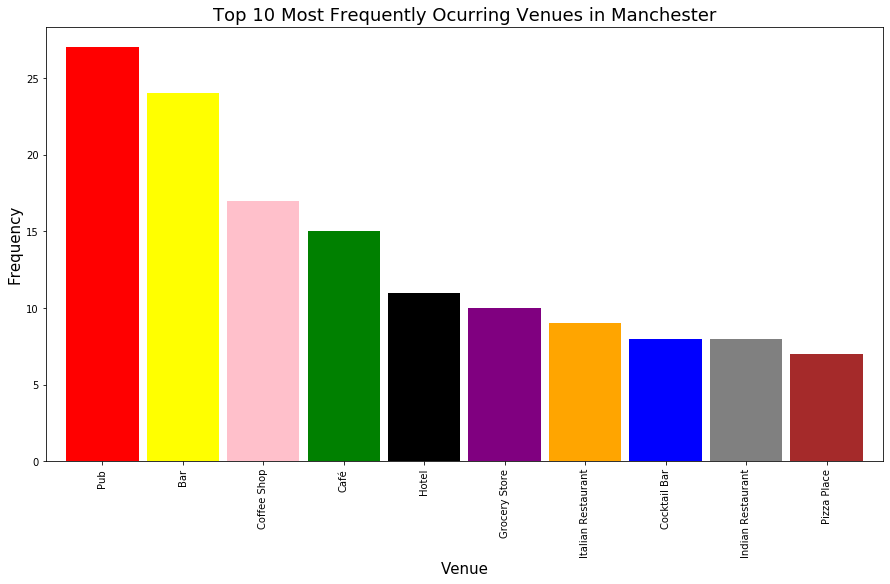

In [27]:
my_colors = ['red','yellow','pink','green','black','purple','orange','blue','grey','brown']
mcr_venues['Venue Category'].value_counts().head(10).plot.bar(figsize=(15,8),color=my_colors,width=0.9)

plt.xlabel('Venue',fontsize=15) # add to x-label to the plot
plt.ylabel('Frequency',fontsize=15) # add y-label to the plot
plt.title('Top 10 Most Frequently Ocurring Venues in Manchester',fontsize=18) # add title to the plot
plt.show()

### 4.3: Analyze Each Neighborhood

In [28]:
# one hot encoding
mcr_onehot = pd.get_dummies(mcr_venues[['Venue Category']], prefix="", prefix_sep="")

# add ward column back to dataframe
mcr_onehot['Ward'] = mcr_venues['Ward'] 

# move ward column to the first column
fixed_columns = [mcr_onehot.columns[-1]] + list(mcr_onehot.columns[:-1])
mcr_onehot = mcr_onehot[fixed_columns]

mcr_onehot.head()

,Ward,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,...,Tea Room,Tennis Court,Thai Restaurant,Theater,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Warehouse Store,Whisky Bar,Wine Bar
0,Ardwick,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ardwick,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ardwick,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ardwick,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Ardwick,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [29]:
mcr_grouped = mcr_onehot.groupby('Ward').mean().reset_index()
mcr_grouped.head()

,Ward,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,...,Tea Room,Tennis Court,Thai Restaurant,Theater,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Warehouse Store,Whisky Bar,Wine Bar
0,Ardwick,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.111111,0.000000,...,0.00000,0.0,0.00000,0.00,0.000000,0.000000,0.0,0.111111,0.0,0.00
1,Chorlton,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.000000,0.142857,...,0.02381,0.0,0.02381,0.00,0.023810,0.047619,0.0,0.000000,0.0,0.00
2,Chorlton Park,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,...,0.00000,0.0,0.00000,0.00,0.111111,0.000000,0.0,0.000000,0.0,0.00
3,Deansgate,0.0,0.0,0.01,0.0,0.04,0.01,0.01,0.010000,0.040000,...,0.00000,0.0,0.03000,0.01,0.000000,0.000000,0.0,0.000000,0.0,0.01
4,Didsbury East,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,...,0.00000,0.0,0.00000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.00


#### Let's print each neighborhood along with the top 5 most common venues

In [30]:
num_top_venues = 5

for hood in mcr_grouped['Ward']:
    print("----"+hood+"----")
    temp = mcr_grouped[mcr_grouped['Ward'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ardwick----
             venue  freq
0              Pub  0.11
1        Pet Store  0.11
2  Warehouse Store  0.11
3   Sandwich Place  0.11
4           Bakery  0.11


----Chorlton----
                venue  freq
0                 Pub  0.19
1                 Bar  0.14
2                Café  0.10
3       Grocery Store  0.10
4  Turkish Restaurant  0.05


----Chorlton Park----
               venue  freq
0      Grocery Store  0.33
1               Park  0.11
2       Tram Station  0.11
3        Fabric Shop  0.11
4  Fish & Chips Shop  0.11


----Deansgate----
                venue  freq
0               Hotel  0.07
1  Italian Restaurant  0.07
2         Coffee Shop  0.06
3                 Pub  0.05
4    Asian Restaurant  0.04


----Didsbury East----
                venue  freq
0                 Pub   0.3
1                Park   0.1
2         Coffee Shop   0.1
3  Chinese Restaurant   0.1
4   Fish & Chips Shop   0.1


----Didsbury West----
          venue  freq
0  Tennis Court  0.09
1           B

#### Let's put that into a *pandas* dataframe

In [31]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Now let's create the new dataframe and display the top 10 venues for each ward.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
wards_venues_sorted = pd.DataFrame(columns=columns)
wards_venues_sorted['Ward'] = mcr_grouped['Ward']

for ind in np.arange(mcr_grouped.shape[0]):
    wards_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mcr_grouped.iloc[ind, :], num_top_venues)

wards_venues_sorted.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ardwick,Sandwich Place,Warehouse Store,Park,Bus Station,Pub,Chinese Restaurant,Pet Store,Fast Food Restaurant,Bakery,Wine Bar
1,Chorlton,Pub,Bar,Grocery Store,Café,Turkish Restaurant,Pizza Place,Gastropub,Cocktail Bar,Pharmacy,Deli / Bodega
2,Chorlton Park,Grocery Store,Convenience Store,Tram Station,Gas Station,Fish & Chips Shop,Fabric Shop,Park,Falafel Restaurant,Comic Shop,Concert Hall
3,Deansgate,Hotel,Italian Restaurant,Coffee Shop,Pub,Bar,Plaza,Asian Restaurant,Thai Restaurant,Spanish Restaurant,Cocktail Bar
4,Didsbury East,Pub,Supermarket,Fish & Chips Shop,Park,Coffee Shop,Gym / Fitness Center,Chinese Restaurant,Hotel,Bakery,Fast Food Restaurant


## Part 5: Cluster Wards

In [32]:
# set number of clusters
kclusters = 3

mcr_grouped_clustering = mcr_grouped.drop('Ward', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mcr_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 0, 1, 1, 1, 0], dtype=int32)

In [33]:
# add clustering labels
wards_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#wards_venues_sorted.drop('Cluster Labels',1,inplace=True)
mcr_merged = mcr_complete

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
mcr_merged = mcr_merged.join(wards_venues_sorted.set_index('Ward'), on='Ward')
mcr_merged.drop('Postcode',inplace=True,axis=1)
mcr_merged # check the last columns!

,Ward,Median price by Ward,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ardwick,191995,53.465800,-2.217067,0,Sandwich Place,Warehouse Store,Park,Bus Station,Pub,Chinese Restaurant,Pet Store,Fast Food Restaurant,Bakery,Wine Bar
1,Chorlton,334000,53.442839,-2.279974,0,Pub,Bar,Grocery Store,Café,Turkish Restaurant,Pizza Place,Gastropub,Cocktail Bar,Pharmacy,Deli / Bodega
2,Chorlton Park,280650,53.435050,-2.267282,2,Grocery Store,Convenience Store,Tram Station,Gas Station,Fish & Chips Shop,Fabric Shop,Park,Falafel Restaurant,Comic Shop,Concert Hall
3,Deansgate,224975,53.478579,-2.246147,0,Hotel,Italian Restaurant,Coffee Shop,Pub,Bar,Plaza,Asian Restaurant,Thai Restaurant,Spanish Restaurant,Cocktail Bar
4,Didsbury East,315000,53.414762,-2.224512,0,Pub,Supermarket,Fish & Chips Shop,Park,Coffee Shop,Gym / Fitness Center,Chinese Restaurant,Hotel,Bakery,Fast Food Restaurant
5,Didsbury West,299995,53.422269,-2.241733,0,Bar,Tennis Court,Pub,Wine Bar,Market,Liquor Store,Café,Deli / Bodega,Fast Food Restaurant,Italian Restaurant
6,Hulme,182500,53.466794,-2.249270,1,Café,Grocery Store,Vegetarian / Vegan Restaurant,Convenience Store,Deli / Bodega,Tanning Salon,Performing Arts Venue,Fast Food Restaurant,Park,Wine Bar
7,Levenshulme,148000,53.444536,-2.186925,1,Café,Indian Restaurant,Pub,Fried Chicken Joint,Farmers Market,Gym / Fitness Center,Sandwich Place,Grocery Store,Antique Shop,Bakery
8,Old Moat,205000,53.435756,-2.233595,1,Convenience Store,Grocery Store,Park,Vegetarian / Vegan Restaurant,Pool,Asian Restaurant,Pub,Indian Restaurant,Burger Joint,Sandwich Place
9,Piccadilly,190000,53.482969,-2.232342,0,Bar,Coffee Shop,Pub,Cocktail Bar,Tea Room,Café,Indian Restaurant,Hotel,Bookstore,Record Shop


Let's plot the 1st Most Common Venue for each cluster

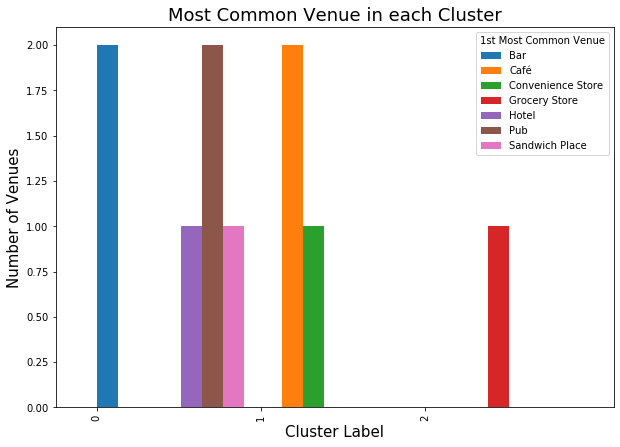

In [34]:
value=pd.DataFrame(mcr_merged.groupby('Cluster Labels')['1st Most Common Venue'].value_counts())
value.rename(columns={'1st Most Common Venue':'Counts'},inplace=True)
value.reset_index(inplace=True)
value.pivot('Cluster Labels','1st Most Common Venue', 'Counts').plot(kind='bar',figsize=(10,7),width=0.9,position=0)

plt.xlabel('Cluster Label',fontsize=15) # add to x-label to the plot
plt.ylabel('Number of Venues',fontsize=15) # add y-label to the plot
plt.title('Most Common Venue in each Cluster',fontsize=18) # add title to the plot
plt.show()

### Adding label columns to the main dataframe

In [36]:
#get the top 3 venues for each ward and add it to the dataframe
mcr_merged['Top 3 Venues'] = mcr_merged[['1st Most Common Venue', '2nd Most Common Venue','3rd Most Common Venue']].apply(lambda x: ','.join(x), axis=1)

#get the prices range labels and add to the dataframe
price_list=[]
for val in mcr_merged['Median price by Ward']:
    if val <=140000:
        label='Low-1 Level Price'
        price_list.append(label)
    elif 140000 < val <= 190000:
        label='Low-2 Level Price'
        price_list.append(label)
    elif 190000 < val <= 240000:
        label='Mid-Level Price'
        price_list.append(label)
    elif 240000 < val <= 290000:
        label='High-1 Level Price'
        price_list.append(label)
    else:
        label='High-2 Level Price'
        price_list.append(label)

#add the list as a column in the dataframe
mcr_merged["Price Labels"] = pd.Series(price_list)

Finally, let's visualize the resulting clusters

In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mcr_merged['Latitude'], mcr_merged['Longitude'], mcr_merged['Ward'], mcr_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Part 6: Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster.

### Cluster 0

In [42]:
#get the ward and the most common venues columns
mcr_merged.loc[mcr_merged['Cluster Labels'] == 0, mcr_merged.columns[[0] + list(range(5, mcr_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Top 3 Venues,Price Labels
0,Ardwick,Pub,Warehouse Store,Chinese Restaurant,Pet Store,Bakery,Sandwich Place,Fast Food Restaurant,Bus Station,Park,Donut Shop,"Pub,Warehouse Store,Chinese Restaurant",Mid-2 Level Price
1,Chorlton,Pub,Bar,Café,Grocery Store,Pizza Place,Turkish Restaurant,Gastropub,Pharmacy,Mediterranean Restaurant,Deli / Bodega,"Pub,Bar,Café",High-2 Level Price
3,Deansgate,Italian Restaurant,Hotel,Coffee Shop,Pub,Asian Restaurant,Bar,Plaza,Burger Joint,Cocktail Bar,Thai Restaurant,"Italian Restaurant,Hotel,Coffee Shop",Mid-2 Level Price
4,Didsbury East,Pub,Supermarket,Hotel,Fish & Chips Shop,Park,Coffee Shop,Chinese Restaurant,Gym / Fitness Center,Bakery,Fast Food Restaurant,"Pub,Supermarket,Hotel",High-2 Level Price
5,Didsbury West,Pub,Tennis Court,Bar,Bakery,Liquor Store,Bus Stop,Café,Deli / Bodega,Cupcake Shop,Italian Restaurant,"Pub,Tennis Court,Bar",High-2 Level Price
9,Piccadilly,Bar,Coffee Shop,Pub,Cocktail Bar,Café,Tea Room,Bookstore,Hotel,Indian Restaurant,Record Shop,"Bar,Coffee Shop,Pub",Mid-1 Level Price


### Cluster 1

In [43]:
mcr_merged.loc[mcr_merged['Cluster Labels'] == 1, mcr_merged.columns[[0] + list(range(5, mcr_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Top 3 Venues,Price Labels
6,Hulme,Café,Grocery Store,Vegetarian / Vegan Restaurant,Convenience Store,Deli / Bodega,Performing Arts Venue,Tanning Salon,Park,Fast Food Restaurant,Wine Bar,"Café,Grocery Store,Vegetarian / Vegan Restaurant",Mid-1 Level Price
7,Levenshulme,Café,Indian Restaurant,Pub,Fried Chicken Joint,Farmers Market,Grocery Store,Sandwich Place,Gym / Fitness Center,Antique Shop,Bakery,"Café,Indian Restaurant,Pub",Mid-1 Level Price
8,Old Moat,Convenience Store,Indian Restaurant,Grocery Store,Vegetarian / Vegan Restaurant,Pool,Asian Restaurant,Pub,Burger Joint,Sandwich Place,Park,"Convenience Store,Indian Restaurant,Grocery Store",Mid-2 Level Price


### Cluster 2

In [44]:
mcr_merged.loc[mcr_merged['Cluster Labels'] == 2, mcr_merged.columns[[0] + list(range(5, mcr_merged.shape[1]))]]

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Top 3 Venues,Price Labels
2,Chorlton Park,Grocery Store,Convenience Store,Tram Station,Gas Station,Fish & Chips Shop,Park,Fabric Shop,Falafel Restaurant,Comic Shop,Concert Hall,"Grocery Store,Convenience Store,Tram Station",High-1 Level Price


### Adding the Cluster Names to the main dataframe

In [38]:
cluster_names=[]
for clust in mcr_merged['Cluster Labels']:
    if clust == 0:
        label='Drinking cluster'
        cluster_names.append(label)
    elif clust == 1:
        label='Eating cluster'
        cluster_names.append(label)
    else:
        label='Residential Cluster'
        cluster_names.append(label)

#add the cluster_names list to the dataframe
mcr_merged["Cluster Names"] = pd.Series(cluster_names)
mcr_merged.head()

,Ward,Median price by Ward,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Top 3 Venues,Price Labels,Cluster Names
0,Ardwick,191995,53.465800,-2.217067,0,Sandwich Place,Warehouse Store,Park,Bus Station,Pub,Chinese Restaurant,Pet Store,Fast Food Restaurant,Bakery,Wine Bar,"Sandwich Place,Warehouse Store,Park",Mid-Level Price,Drinking cluster
1,Chorlton,334000,53.442839,-2.279974,0,Pub,Bar,Grocery Store,Café,Turkish Restaurant,Pizza Place,Gastropub,Cocktail Bar,Pharmacy,Deli / Bodega,"Pub,Bar,Grocery Store",High-2 Level Price,Drinking cluster
2,Chorlton Park,280650,53.435050,-2.267282,2,Grocery Store,Convenience Store,Tram Station,Gas Station,Fish & Chips Shop,Fabric Shop,Park,Falafel Restaurant,Comic Shop,Concert Hall,"Grocery Store,Convenience Store,Tram Station",High-1 Level Price,Residential Cluster
3,Deansgate,224975,53.478579,-2.246147,0,Hotel,Italian Restaurant,Coffee Shop,Pub,Bar,Plaza,Asian Restaurant,Thai Restaurant,Spanish Restaurant,Cocktail Bar,"Hotel,Italian Restaurant,Coffee Shop",Mid-Level Price,Drinking cluster
4,Didsbury East,315000,53.414762,-2.224512,0,Pub,Supermarket,Fish & Chips Shop,Park,Coffee Shop,Gym / Fitness Center,Chinese Restaurant,Hotel,Bakery,Fast Food Restaurant,"Pub,Supermarket,Fish & Chips Shop",High-2 Level Price,Drinking cluster


# Choropleth Maps <a id="8"></a>

A `Choropleth` map is a thematic map in which areas are shaded or patterned in proportion to the measurement of the statistical variable being displayed on the map, such as population density or per-capita income. The choropleth map provides an easy way to visualize how a measurement varies across a geographic area or it shows the level of variability within a region.

In order to create a `Choropleth` map, we need a GeoJSON file that defines the areas/boundaries of the state, county, or country that we are interested in. In our case, since we will create a map of Manchester, we want a GeoJSON that defines the boundaries of all wards in the city. 

In [39]:
# download countries geojson file
mcr_geo = open('/resources/data/Manchester/All_wards.geojson', 'r', encoding='utf-8-sig').read()

### Choropleth Map showing the number of venues per ward

In [44]:
# generate choropleth map using the total number of venues of each ward in Manchester
man_map.choropleth(
    geo_data=mcr_geo,
    data=mcr_top10,
    columns=['Ward', 'Venue'],
    key_on='feature.properties.Name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Total number of venues'
)

# display map
man_map

### Choropleth map showing the median property price for each ward in Manchester

In [45]:
# create map
map_price = folium.Map(location=[latitude, longitude], zoom_start=11.2)
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
map_price.choropleth(
    geo_data=mcr_geo,
    data=df_merge,
    columns=['Ward', 'Median price by Ward'],
    key_on='feature.properties.Name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Median Property Price (£)'
)

map_price

In [47]:
# add markers to the map
markers_colors = []
i=0
for lat, lon, poi, cluster,name,price in zip(mcr_merged['Latitude'], mcr_merged['Longitude'], mcr_merged['Ward'],mcr_merged['Cluster Labels'], mcr_merged['Cluster Names'],mcr_merged['Price Labels']):
    label = folium.Popup(str(poi) + ',' + str(name)+ ','+ str(price), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_price)
    
# display map
map_price